# Problem Statement

Urban and semi-urban tree plantation initiatives frequently experience high sapling mortality,
resulting in inefficient use of resources and reduced long-term environmental impact.
A key contributor to this issue is the absence of data-driven decision support systems
that can quantify survival risk and guide plantation planning based on empirical evidence.

Most plantation strategies rely on generalized guidelines that do not account for
species-specific characteristics, environmental conditions, or temporal survival dynamics.
As a result, plantation timing and site selection are often suboptimal, leading to avoidable failures.

Given a historical dataset of tree plantation experiments containing environmental attributes,
species information, plantation dates, and observed survival outcomes over time,
the objective is to develop an AI-driven analytical framework that:

- Models the time-to-failure of planted trees using survival analysis techniques
- Quantifies survival probability under varying environmental and biological conditions
- Identifies periods associated with higher plantation success based on historical outcomes

The dataset contains incomplete and censored observations, where not all planted trees
experience the event of interest (death) within the observation window.
Therefore, the problem is formulated primarily as a **survival analysis task**,
using the variables `Time` (duration) and `Event` (event occurrence) to correctly
capture both observed failures and censored instances.

The resulting system is intended to function as a **decision-support tool** for planners
and policymakers, providing evidence-based insights rather than automated control actions.
Real-time sensing, weather forecasting, and operational deployment are outside the scope
of this study.


In [ ]:
!pip install lifelines

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter

In [ ]:
df = pd.read_csv("Tree_Data.csv")
df.head()

,No,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Adult,Sterile,...,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Alive
0,126,1,C,Acer saccharum,0.106,Med,2017,Prunus serotina,I,Non-Sterile,...,22.00,NaN,-0.56,13.86,12.15,4,14.0,1.0,NaN,NaN
1,11,1,C,Quercus alba,0.106,Med,2017,Quercus rubra,970,Non-Sterile,...,15.82,31.07,5.19,20.52,19.29,33,115.5,0.0,NaN,X
2,12,1,C,Quercus rubra,0.106,Med,2017,Prunus serotina,J,Non-Sterile,...,24.45,28.19,3.36,24.74,15.01,18,63.0,1.0,NaN,NaN
3,2823,7,D,Acer saccharum,0.080,Med,2016,Prunus serotina,J,Non-Sterile,...,22.23,NaN,-0.71,14.29,12.36,4,14.0,1.0,NaN,NaN
4,5679,14,A,Acer saccharum,0.060,Low,2017,Prunus serotina,689,Non-Sterile,...,21.15,NaN,-0.58,10.85,11.20,4,14.0,1.0,NaN,NaN


In [ ]:
df.shape

(2783, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           2783 non-null   int64  
 1   Plot         2783 non-null   int64  
 2   Subplot      2783 non-null   object 
 3   Species      2783 non-null   object 
 4   Light_ISF    2783 non-null   float64
 5   Light_Cat    2783 non-null   object 
 6   Core         2783 non-null   int64  
 7   Soil         2783 non-null   object 
 8   Adult        2783 non-null   object 
 9   Sterile      2783 non-null   object 
 10  Conspecific  2783 non-null   object 
 11  Myco         2783 non-null   object 
 12  SoilMyco     2783 non-null   object 
 13  PlantDate    2783 non-null   object 
 14  AMF          2783 non-null   float64
 15  EMF          1283 non-null   float64
 16  Phenolics    2783 non-null   float64
 17  Lignin       2783 non-null   float64
 18  NSC          2783 non-null   float64
 19  Census

In [ ]:
df.describe()

,No,Plot,Light_ISF,Core,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,1283.00000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2782.000000
mean,3914.513834,9.561624,0.085707,2016.648940,20.553069,26.47675,1.933105,15.759792,14.219641,15.282070,53.487244,0.570453
std,2253.515063,5.203659,0.025638,0.477387,12.309587,16.63689,1.969842,6.779607,4.298271,9.166555,32.082942,0.495100
min,3.000000,1.000000,0.032000,2016.000000,0.000000,0.00000,-1.350000,2.230000,4.300000,4.000000,14.000000,0.000000
25%,1971.000000,5.000000,0.066000,2016.000000,13.400000,13.78000,0.170000,10.355000,11.605000,7.000000,24.500000,0.000000
50%,3932.000000,10.000000,0.082000,2017.000000,18.000000,27.72000,0.750000,14.040000,12.660000,13.000000,45.500000,1.000000
75%,5879.000000,14.000000,0.100000,2017.000000,24.445000,35.71000,3.780000,21.115000,17.275000,18.000000,63.000000,1.000000
max,7772.000000,18.000000,0.161000,2017.000000,100.000000,87.50000,6.100000,32.770000,29.450000,33.000000,115.500000,1.000000


In [ ]:
print(df.isnull().sum())

No                0
Plot              0
Subplot           0
Species           0
Light_ISF         0
Light_Cat         0
Core              0
Soil              0
Adult             0
Sterile           0
Conspecific       0
Myco              0
SoilMyco          0
PlantDate         0
AMF               0
EMF            1500
Phenolics         0
Lignin            0
NSC               0
Census            0
Time              0
Event             1
Harvest        2079
Alive          2292
dtype: int64


In [ ]:
print(df.columns.tolist())

['No', 'Plot', 'Subplot', 'Species', 'Light_ISF', 'Light_Cat', 'Core', 'Soil', 'Adult', 'Sterile', 'Conspecific', 'Myco', 'SoilMyco', 'PlantDate', 'AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC', 'Census', 'Time', 'Event', 'Harvest', 'Alive']


In [ ]:
df['Alive'].value_counts(dropna=False)
df['Alive'].isna().mean()

np.float64(0.8235716852317643)

In [ ]:
duration_col = "Time"
event_col = "Event"
print(df[[duration_col, event_col]].head())

    Time  Event
0   14.0    1.0
1  115.5    0.0
2   63.0    1.0
3   14.0    1.0
4   14.0    1.0


In [ ]:
event_rate = df[event_col].mean()
censor_rate = 1 - event_rate

event_rate, censor_rate

(np.float64(0.5704529115744069), np.float64(0.4295470884255931))

In [ ]:
for col in ['Event', 'Subplot', 'Species', 'Light_Cat', 'Soil', 'Sterile', 'Conspecific', 'Myco', 'SoilMyco']:
    print(df[col].value_counts())
    print(".............")

Event
1.0    1587
0.0    1195
Name: count, dtype: int64
.............
Subplot
A    701
D    666
B    663
C    646
E    107
Name: count, dtype: int64
.............
Species
Acer saccharum     751
Prunus serotina    749
Quercus alba       673
Quercus rubra      610
Name: count, dtype: int64
.............
Light_Cat
Med     1474
Low     1005
High     304
Name: count, dtype: int64
.............
Soil
Sterile                  423
Prunus serotina          413
Quercus rubra            402
Acer saccharum           397
Populus grandidentata    391
Quercus alba             381
Acer rubrum              376
Name: count, dtype: int64
.............
Sterile
Non-Sterile    2360
Sterile         423
Name: count, dtype: int64
.............
Conspecific
Heterospecific    1974
Sterilized         423
Conspecific        386
Name: count, dtype: int64
.............
Myco
AMF    1500
EMF    1283
Name: count, dtype: int64
.............
SoilMyco
AMF        1186
EMF        1174
Sterile     423
Name: count, dtype: int64

In [ ]:
drop_cols = ['No', 'Core', 'Subplot', 'Harvest', 'Alive', 'Plot', 'SoilMyco', 'Adult']
df = df.drop(columns=drop_cols)

*   No: pure ID
*   Core: Experiment-year identifier, leaks structure (2016-17)
*   Plot and Subplot: Can create overfitting, Adds noise, not biology, Manipulates feature space during encoding
*   Alive: Redundunt with Event, Event(Exists) Hence this is useless
*   Harvest: It is an administrative outcome, not a survival predictor
* SoilMyco: It has same data as like Mycotype and has Sterile at some places, making the dataset redendent

In [ ]:
df['PlantDate'] = pd.to_datetime(df['PlantDate'], errors='coerce')
df['PlantMonth'] = df['PlantDate'].dt.month
def season_from_month(month):
    if month in [6, 7, 8, 9]:
        return 'Monsoon'
    elif month in [10, 11]:
        return 'PostMonsoon'
    elif month in [12, 1, 2]:
        return 'Winter'
    else:
        return 'Summer'
df['PlantSeason'] = df['PlantMonth'].apply(season_from_month)
df = df.drop(columns=['PlantDate', 'PlantMonth'])

/tmp/ipython-input-387900726.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['PlantDate'] = pd.to_datetime(df['PlantDate'], errors='coerce')


In [ ]:
emf_imputer = SimpleImputer(strategy='median')
df['EMF'] = emf_imputer.fit_transform(df[['EMF']])

In [ ]:
df = df[df['Event'].notna()]

In [ ]:
print(df.isnull().sum())

Species        0
Light_ISF      0
Light_Cat      0
Soil           0
Sterile        0
Conspecific    0
Myco           0
AMF            0
EMF            0
Phenolics      0
Lignin         0
NSC            0
Census         0
Time           0
Event          0
PlantSeason    0
dtype: int64


In [ ]:
df['Census'] = df['Census'].astype('category')

In [ ]:
X = df.drop(columns=[duration_col, event_col])
y_time = df[duration_col]
y_event = df[event_col]
y = df[[duration_col, event_col]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(num_cols)
print(cat_cols)

['Light_ISF', 'AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC']
['Species', 'Light_Cat', 'Soil', 'Sterile', 'Conspecific', 'Myco', 'Census', 'PlantSeason']


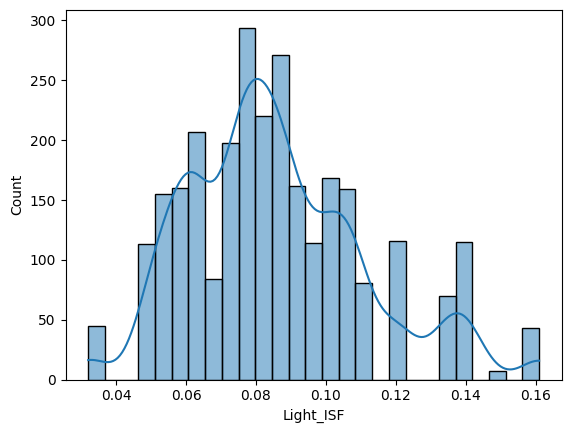

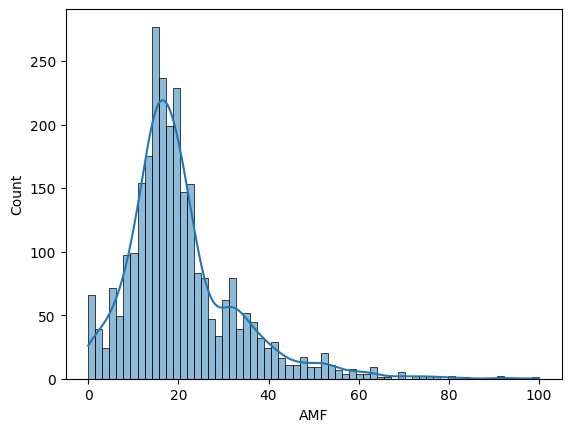

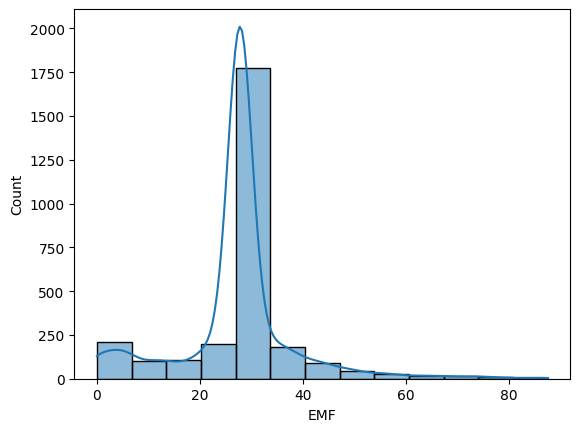

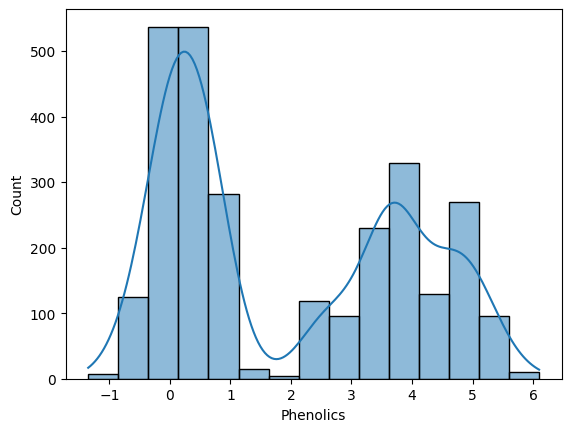

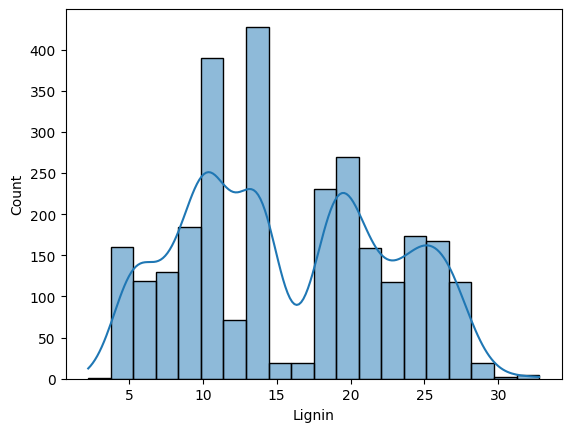

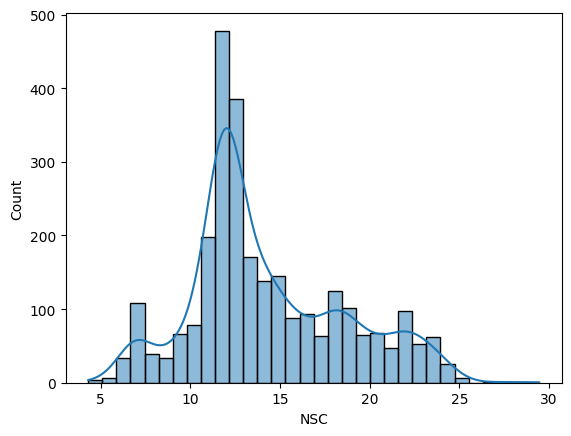

In [ ]:
for f in num_cols:
    sns.histplot(df[f], kde=True)
    plt.show()

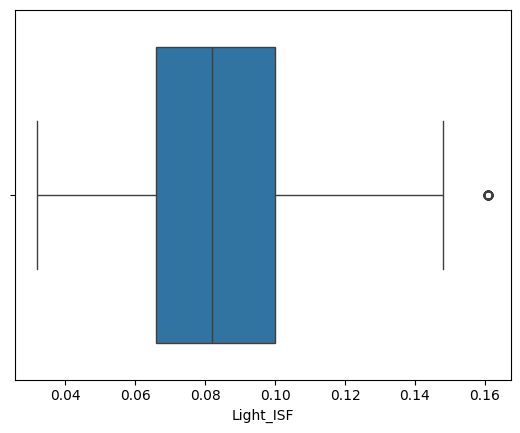

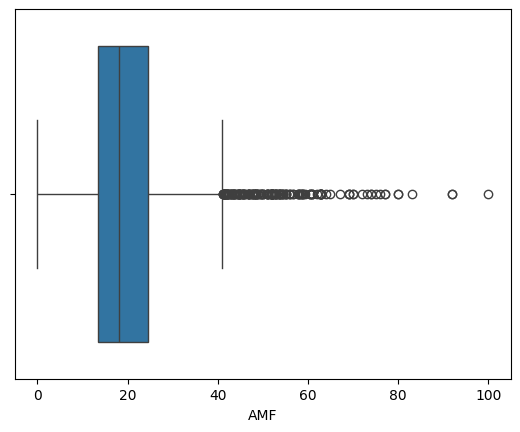

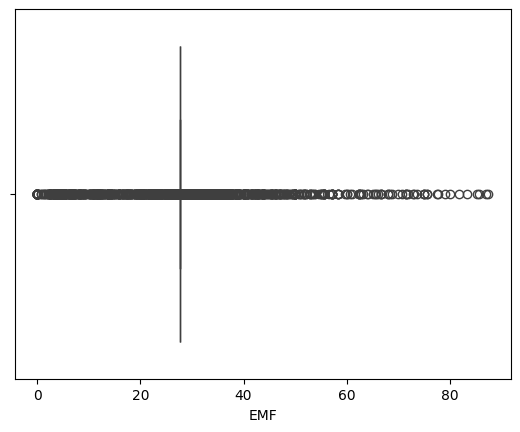

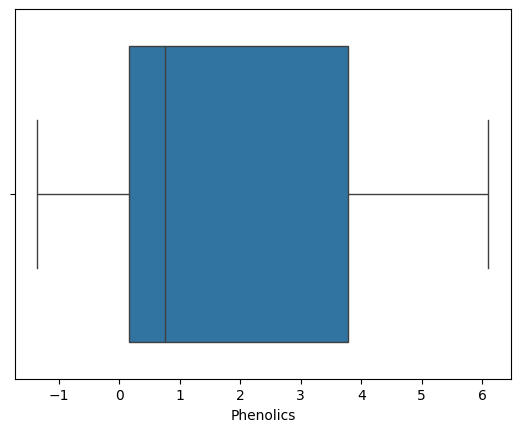

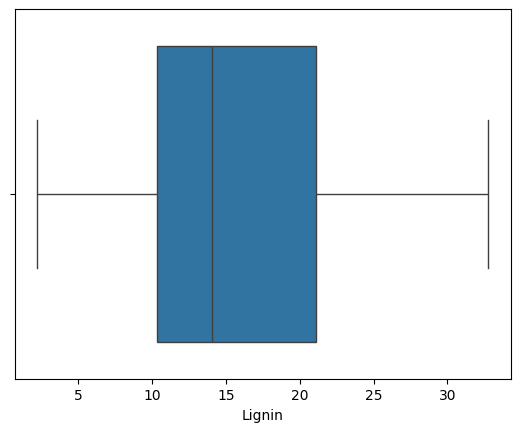

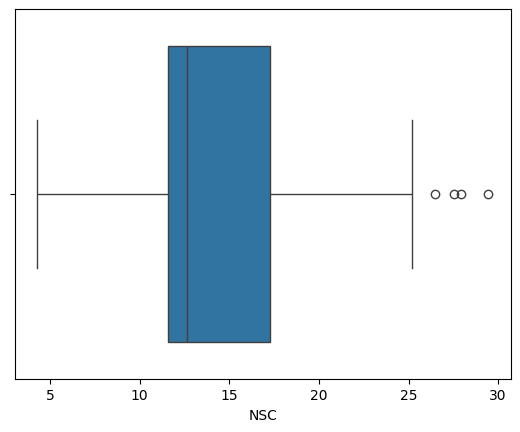

In [ ]:
for f in num_cols:
    sns.boxplot(x=df[f])
    plt.show()

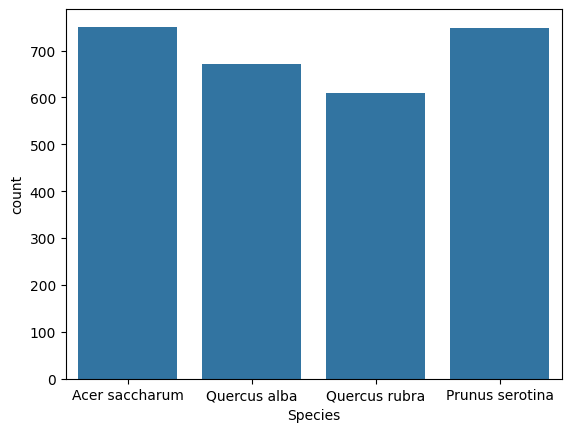

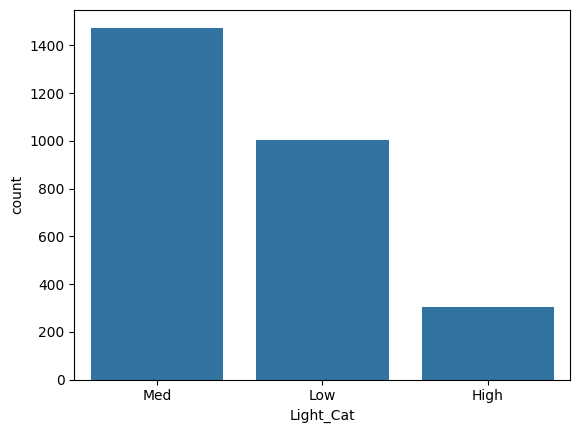

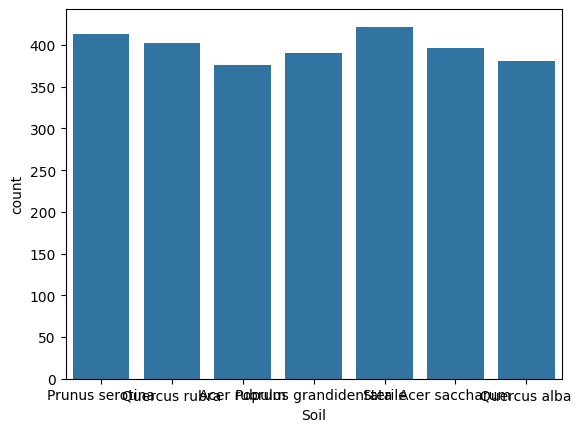

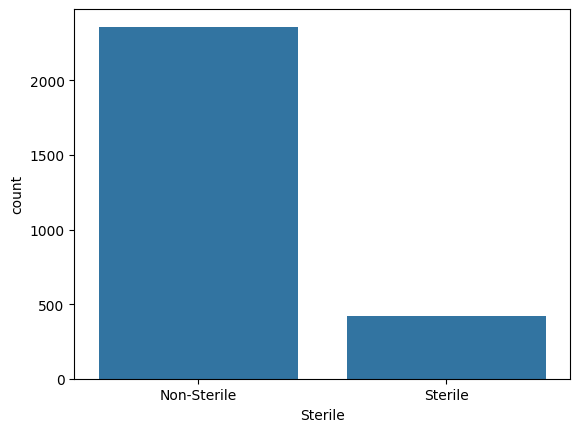

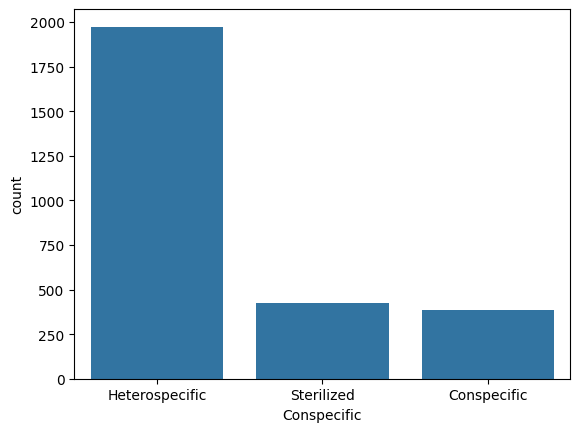

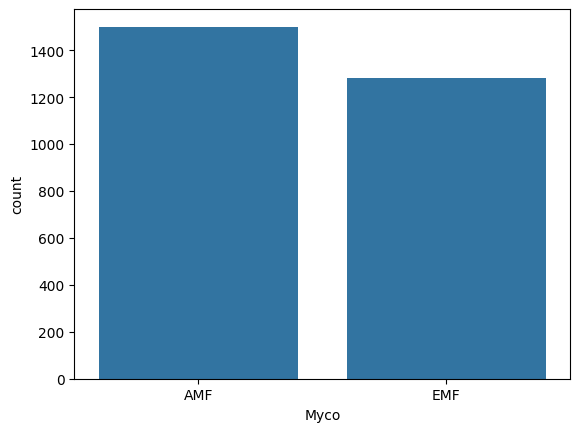

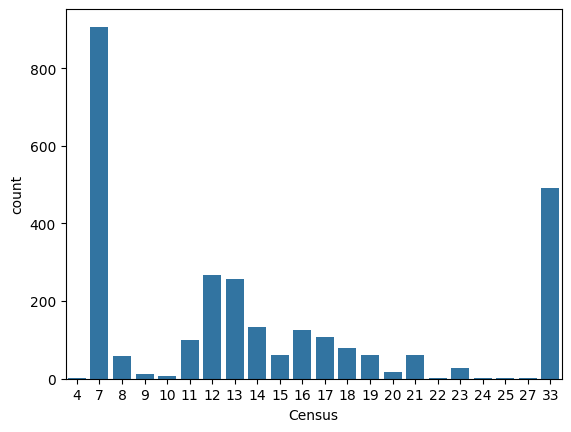

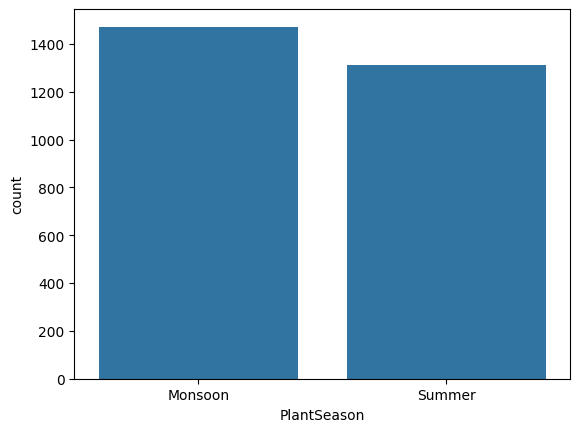

In [ ]:
for f in cat_cols:
    sns.countplot(x=f, data=df)
    plt.show()

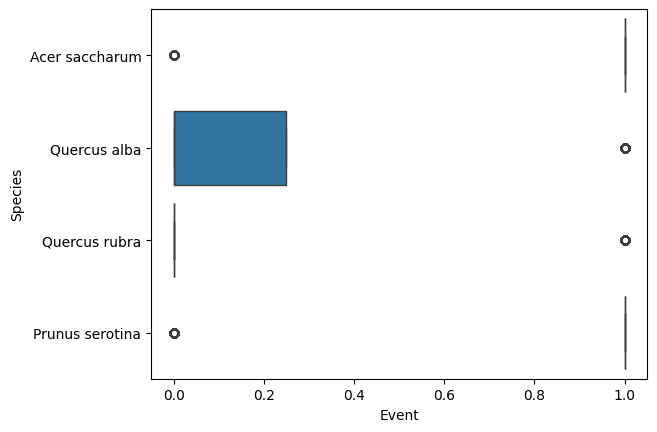

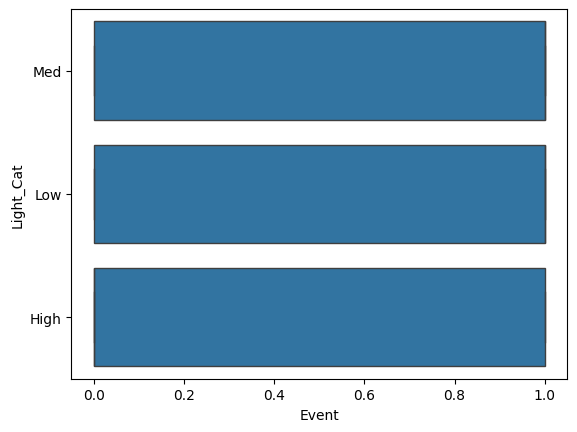

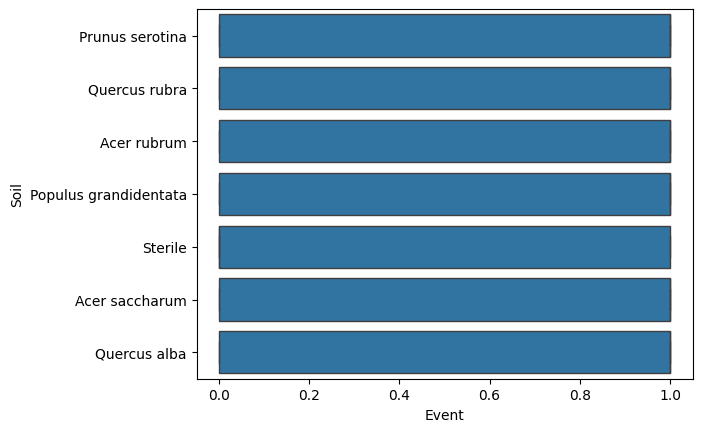

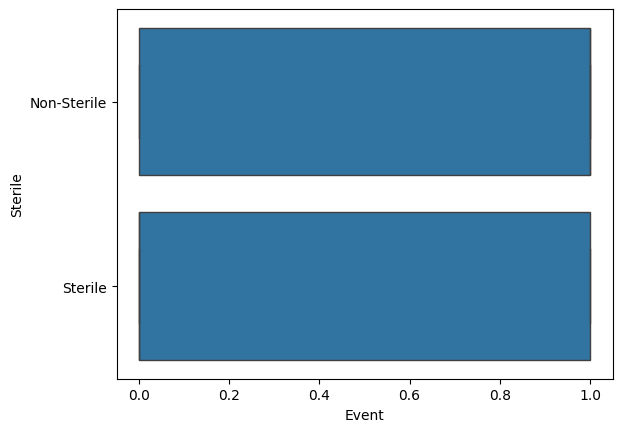

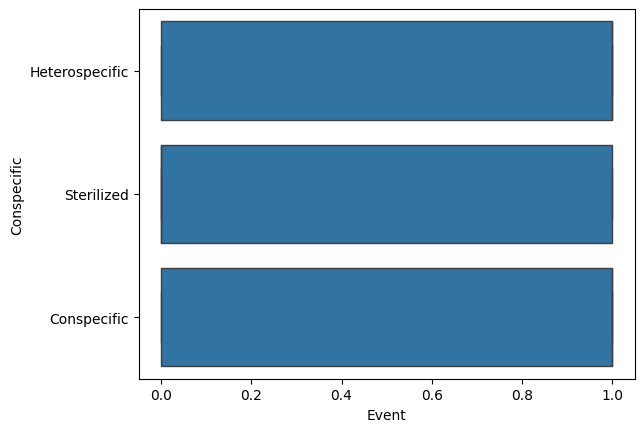

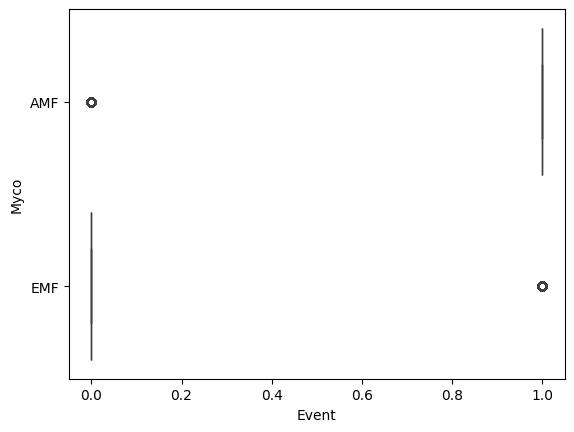

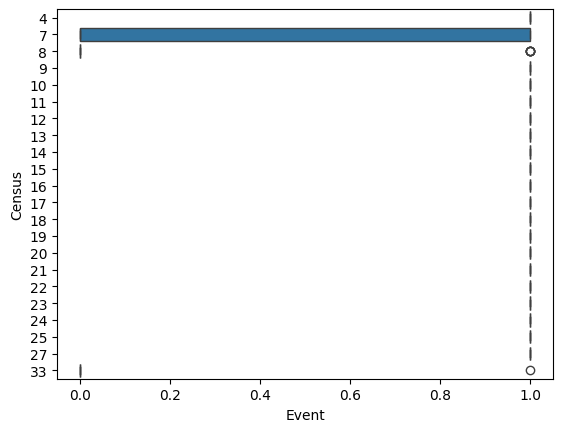

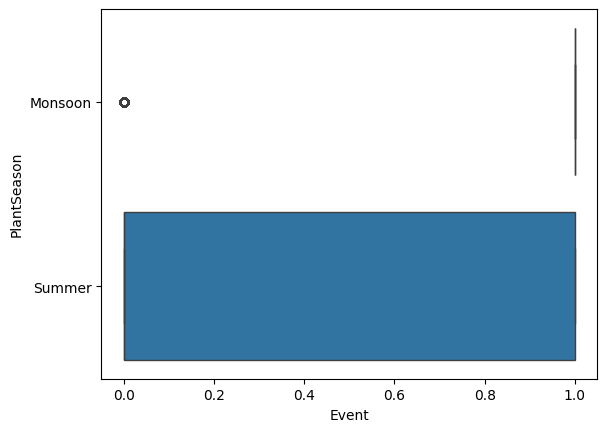

In [ ]:
for f in cat_cols:
    sns.boxplot(x=y_event, y=f, data=df)
    plt.show()

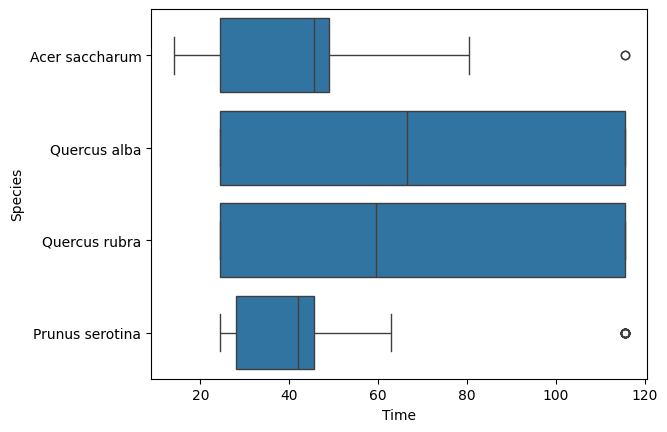

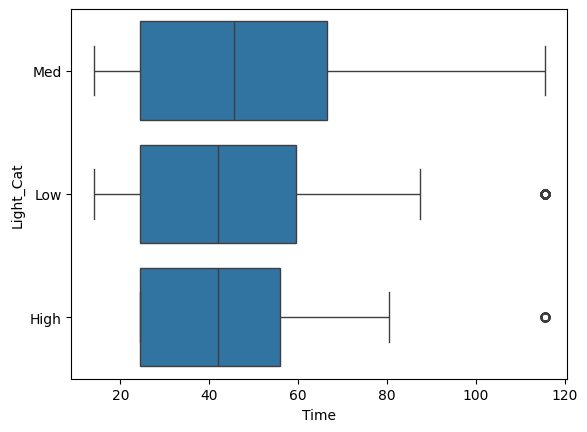

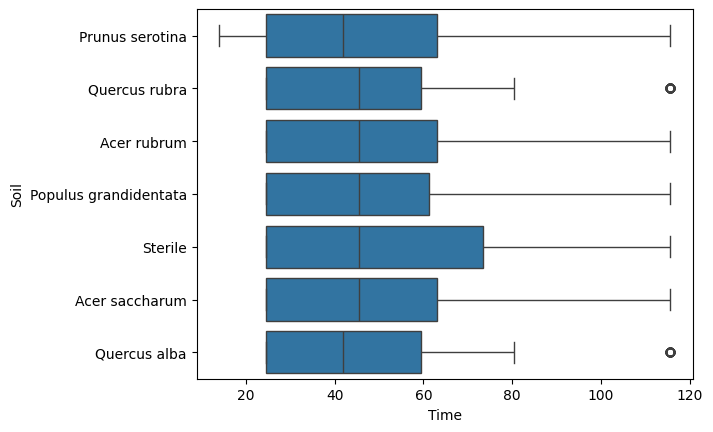

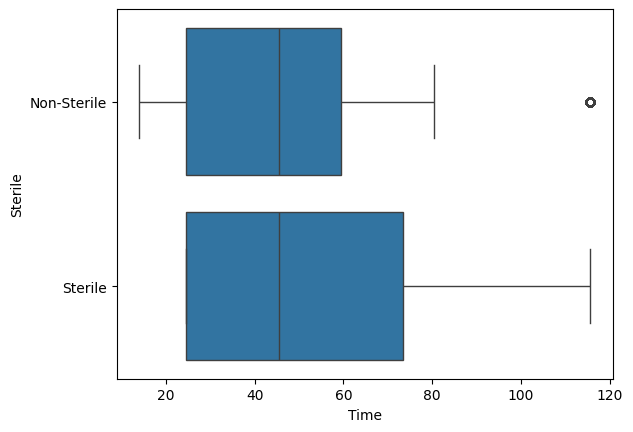

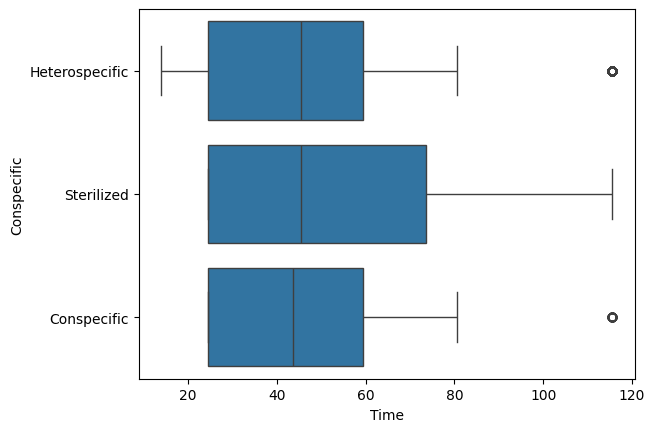

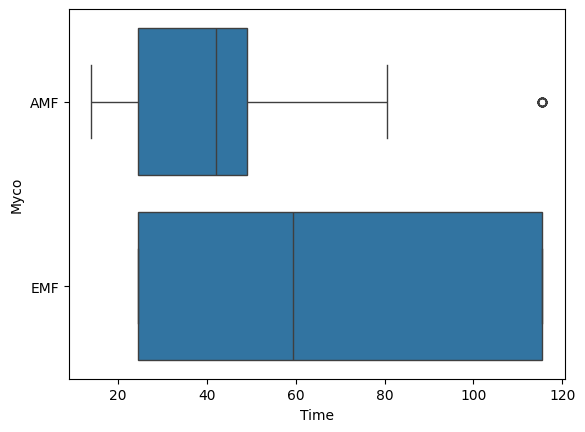

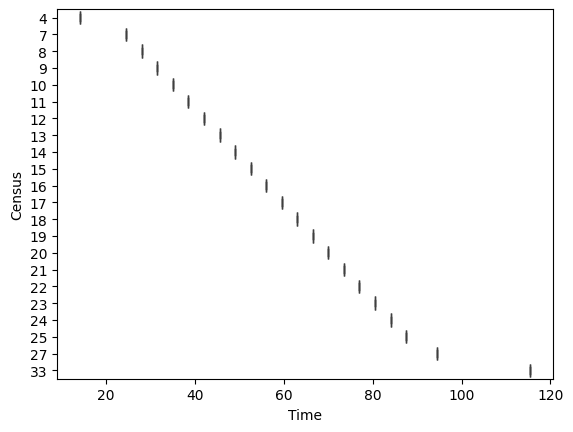

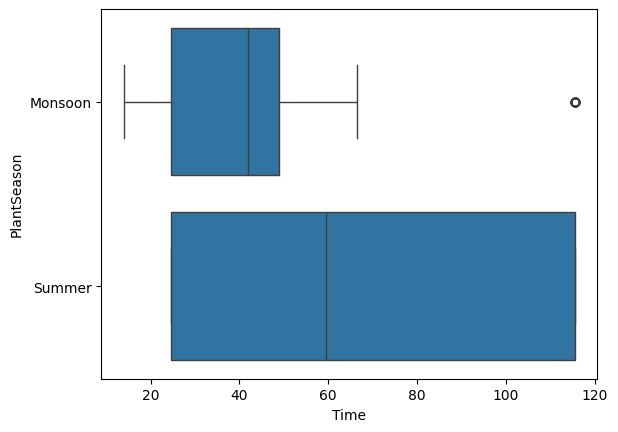

In [ ]:
for f in cat_cols:
    sns.boxplot(x=y_time, y=f, data=df)
    plt.show()

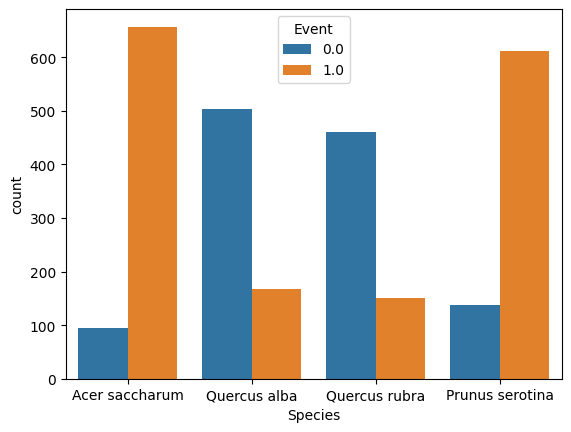

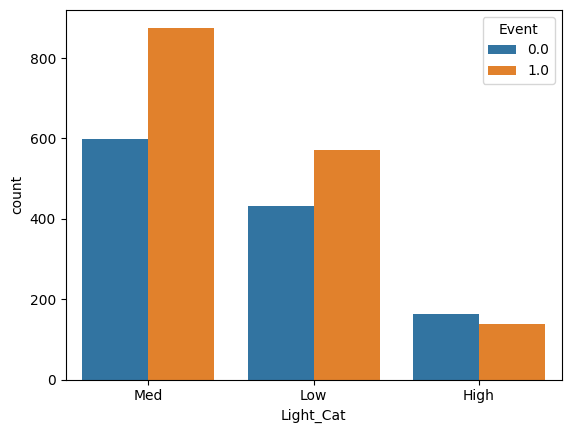

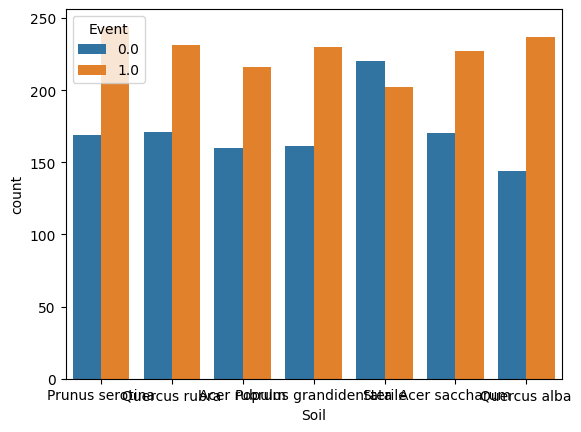

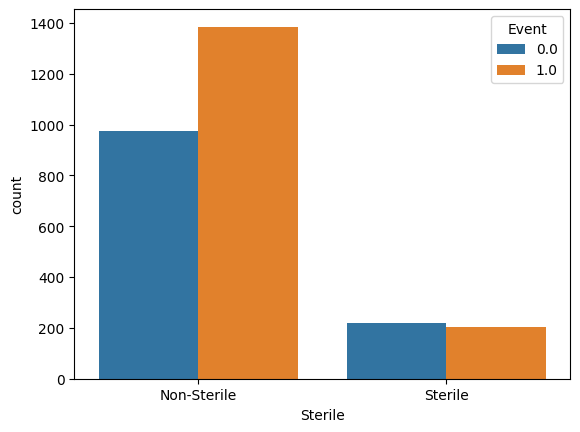

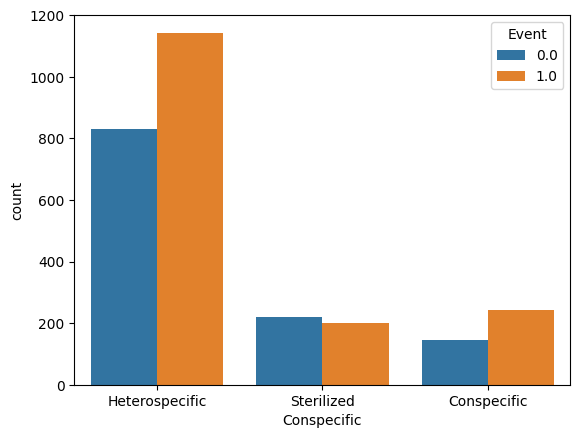

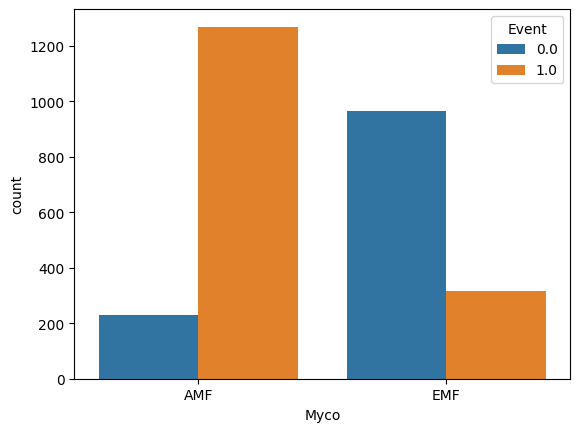

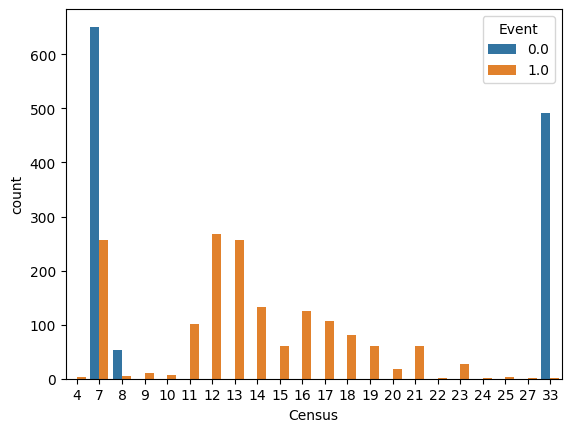

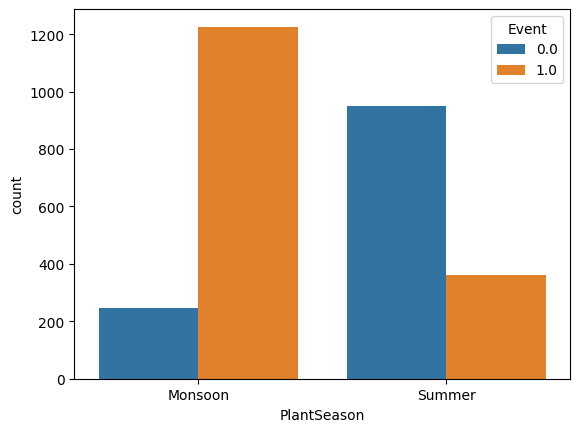

In [ ]:
for f in cat_cols:
    sns.countplot(x=f, hue=y_event, data=df)
    plt.show()

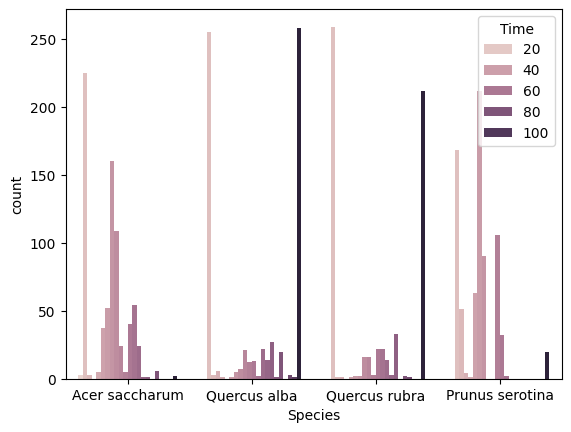

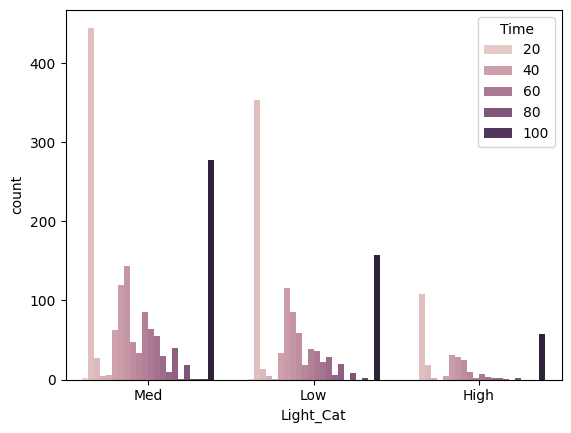

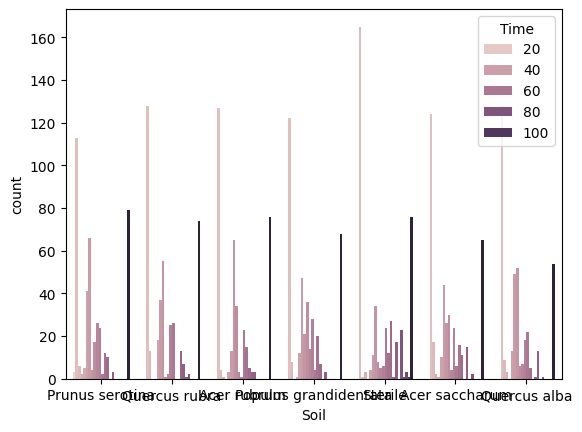

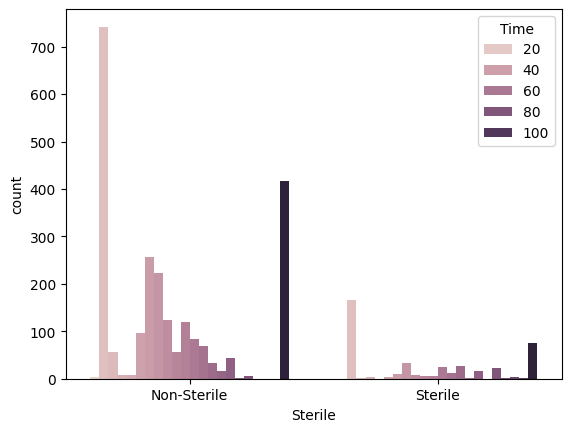

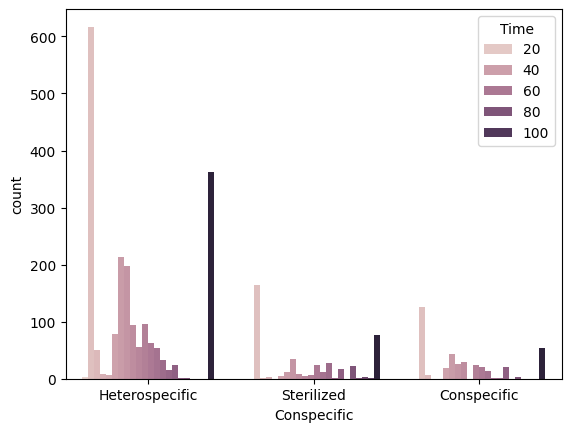

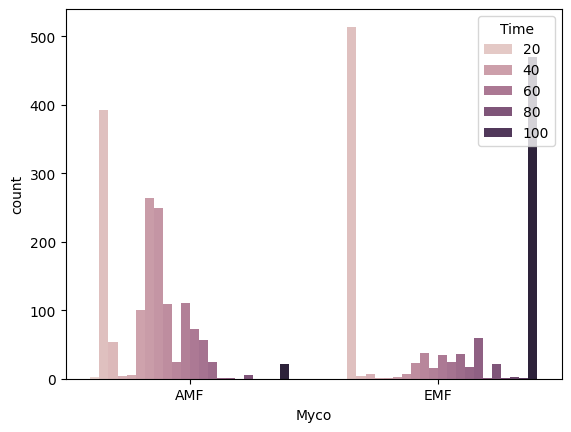

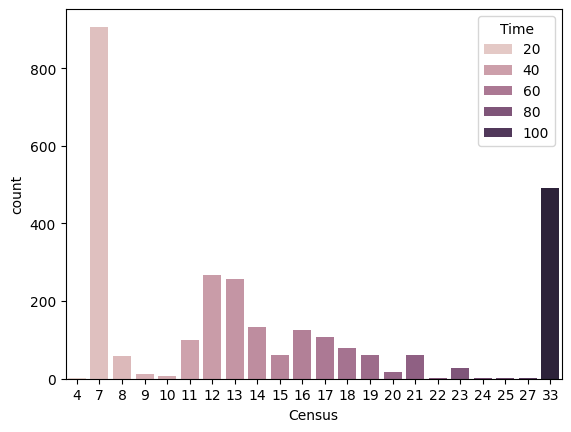

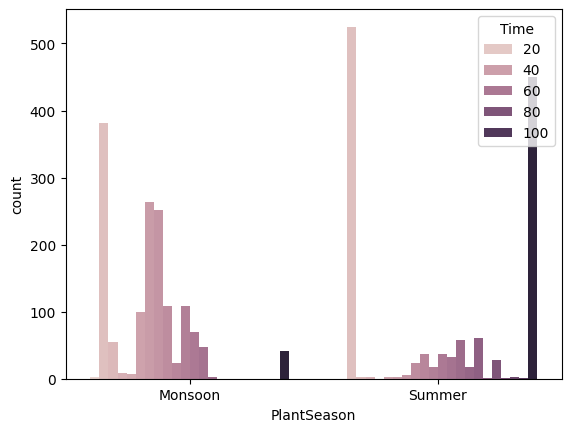

In [ ]:
for f in cat_cols:
    sns.countplot(x=f, hue=y_time, data=df)
    plt.show()

In [ ]:
df['AMF'] = df['AMF'].clip(upper=df['AMF'].quantile(0.99))

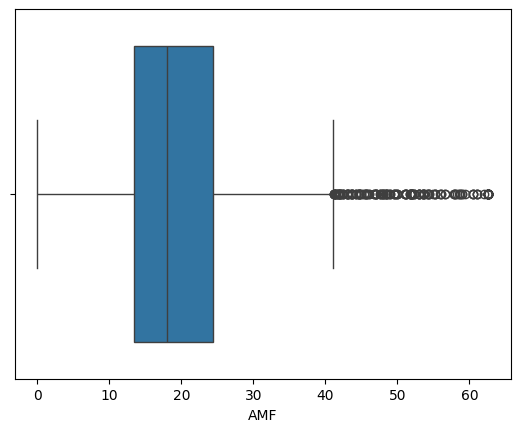

In [ ]:
sns.boxplot(x=df['AMF'])
plt.show()

Keeps information, limits damage.

In [ ]:
df['EMF_log'] = np.log1p(df['EMF'])
df = df.drop(columns=['EMF'])

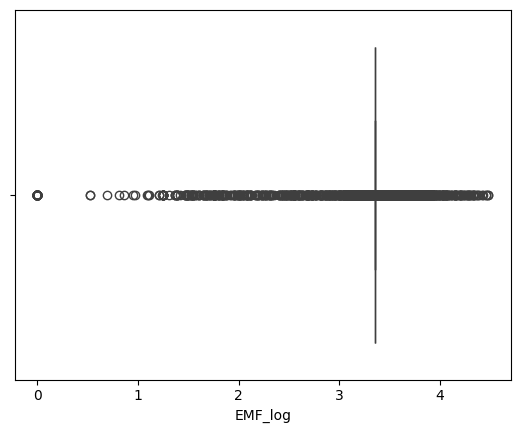

In [ ]:
sns.boxplot(x=df['EMF_log'])
plt.show()

In [ ]:
df = df.rename(columns={'EMF': 'EMF_exposure', 'Myco': 'Myco_type'})

EMF showed strong right skew with extreme values, so we applied a log transformation to stabilize variance and reduce undue influence of extreme exposures, improving proportional hazards behavior.

## Survival Outcome and Censoring

The primary outcome variables are:
- `Event`: indicates whether tree death occurred (1) or the observation was censored (0)
- `Time`: duration from planting to death or end of observation

Exploratory analysis shows a significant proportion of censored observations,
indicating that many trees remained alive beyond the recorded study period.
This confirms that standard classification approaches would fail to capture
the temporal dynamics of survival.

The presence of censoring justifies the use of survival analysis techniques,
which can correctly model both observed failures and incomplete observations.

## Survival Trends Across Environmental Conditions

The Kaplan–Meier survival curve shows that tree mortality is time-dependent rather than uniform.
Survival remains high immediately after planting, followed by a sharp decline between roughly
30–60 time units, indicating a critical vulnerability period. After this phase, survival
probability stabilizes, suggesting that trees surviving beyond this window are more likely
to persist long term.

This confirms the suitability of survival analysis and highlights the importance of
focusing on early-stage survival drivers in both modeling and plantation planning.


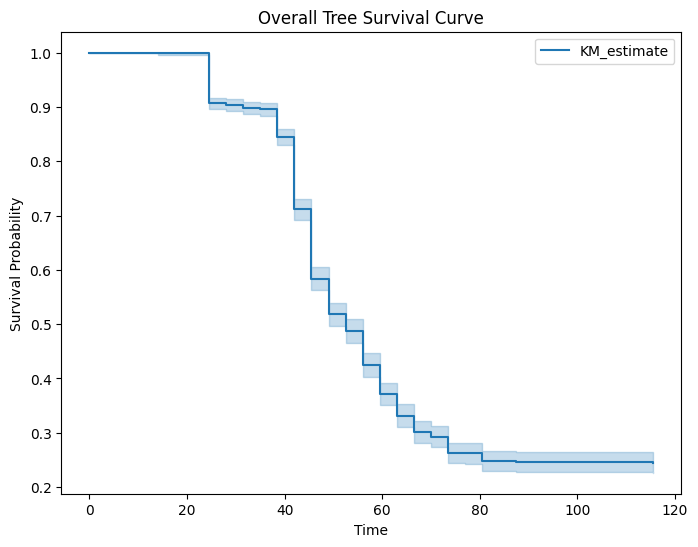

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
kmf.fit(durations=df["Time"], event_observed=df["Event"])
kmf.plot_survival_function()
plt.title("Overall Tree Survival Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

## Summary of Key Data Insights

- Tree survival outcomes exhibit significant censoring, necessitating survival analysis
- Missing data contains meaningful ecological information and should not be ignored
- Environmental variability and outliers reflect real-world conditions
- Survival probability varies across environmental and biological factors
- Plantation timing influences survival outcomes, indicating optimizable windows

These insights validate the problem formulation and establish a strong foundation
for the development of predictive survival models.

In [ ]:
df.shape

(2782, 16)

In [ ]:
# Some Checks
df['Event'] = df['Event'].astype(int)
df['Time'] = df['Time'].astype(float)
df = df[df['Time'] > 0]

In [ ]:
df.drop_duplicates()

,Species,Light_ISF,Light_Cat,Soil,Sterile,Conspecific,Myco_type,AMF,Phenolics,Lignin,NSC,Census,Time,Event,PlantSeason,EMF_log
0,Acer saccharum,0.106,Med,Prunus serotina,Non-Sterile,Heterospecific,AMF,22.00,-0.56,13.86,12.15,4,14.0,1,Monsoon,3.357594
1,Quercus alba,0.106,Med,Quercus rubra,Non-Sterile,Heterospecific,EMF,15.82,5.19,20.52,19.29,33,115.5,0,Summer,3.467921
2,Quercus rubra,0.106,Med,Prunus serotina,Non-Sterile,Heterospecific,EMF,24.45,3.36,24.74,15.01,18,63.0,1,Summer,3.373826
3,Acer saccharum,0.080,Med,Prunus serotina,Non-Sterile,Heterospecific,AMF,22.23,-0.71,14.29,12.36,4,14.0,1,Monsoon,3.357594
4,Acer saccharum,0.060,Low,Prunus serotina,Non-Sterile,Heterospecific,AMF,21.15,-0.58,10.85,11.20,4,14.0,1,Monsoon,3.357594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777,Quercus alba,0.122,High,Quercus rubra,Non-Sterile,Heterospecific,EMF,10.89,5.53,21.44,18.99,16,56.0,1,Summer,3.688879
2778,Prunus serotina,0.111,Med,Populus grandidentata,Non-Sterile,Heterospecific,AMF,40.89,0.83,9.15,11.88,16,56.0,1,Monsoon,3.357594
2779,Quercus alba,0.118,Med,Acer rubrum,Non-Sterile,Heterospecific,EMF,15.47,4.88,19.01,23.50,16,56.0,1,Summer,3.521052
2780,Quercus alba,0.118,Med,Quercus rubra,Non-Sterile,Heterospecific,EMF,11.96,5.51,21.13,19.10,16,56.0,1,Summer,3.655064


In [ ]:
df.to_csv('Tree_Data2.csv', index=False)